# Sign Language

The problem I chose was to predict, given a photograph of a hand doing something some symbol (letter) in sign language, be able to get the letter or symbol described.

<br />
<br />

## The dataset / Business Understanding

In my case, the dataset that most balanced clean data with a large amount of information was a fairly famous one, the MNIST Sign Language.

The original MNIST image data set, you know the one we all know of the handwritten digits is a quite popular benchmark for machine learning methods, but researchers have renewed their efforts to update it and develop replacements directives that are more challenging for computer vision and original for real-world applications.

<img src="./Report/Graphics/bnw.png" width="60%" />
        
The MNIST presented here follows the same CSV format with labels and pixel values in individual rows.

The American Sign Language database of hand gestures represents a multi-class problem with 24 letter classes (excluding J and Z that require movement).

That is why we are only going to use 25 classes (we could do 24, but since the missing class is 9 I thought more coherently leave them at 25).

The dataset format is designed to closely match the classic MNIST. Each training and testing case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and there are no cases for 9 = J or 25 = Z due to gestural movements). The training data (27,455 cases) and the test data (7172 cases) are about half the size of the standard MNIST, but are otherwise similar with a tag header row, pixel1, pixel2 ... pixel784 representing a single 28x28 pixel image with scale values of grays between 0-255.

The original data from the hand gesture image represented multiple users who they repeated the gesture on different backgrounds. The MNIST sign language data comes from a large extent of the small number (1704) of the color images included as not cropped around the region of interest in hand. To create new data, an ImageMagick-based image pipeline was used and included hand-only cropping, grayscale, resizing and then creating at least 50+ variations to increase the quantity.

In my case I downloaded it from Kaggle and you can find it at the following link: https://www.kaggle.com/datamunge/sign-language-mnist

<img src="./Report/Graphics/images.png" width="60%" />

In [46]:
!python3 --version

Python 3.8.5


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
def dataframe_to_data(raw):
    labels = raw['label']
    raw.drop('label', axis=1, inplace=True)

    return raw.values, labels.values

In [49]:
base_url = "./dataset/"

data_url = base_url + "sign_mnist_test.csv"
data_raw = pd.read_csv(data_url, sep=",")
data, labels = dataframe_to_data(data_raw)
print("data:", len(data))

test_url = base_url + "sign_mnist_test.csv"
test_validation_data_raw = pd.read_csv(test_url, sep=",")

n = len(test_validation_data_raw)
test_data_raw       = test_validation_data_raw.loc[:n//2, :].copy()
validation_data_raw = test_validation_data_raw.loc[n//2:, :].copy()

test_data, labels_test = dataframe_to_data(test_data_raw)
print("test:", len(test_data))

validation_data, labels_validation = dataframe_to_data(validation_data_raw)
print("validation:", len(validation_data))

data: 7172
test: 3587
validation: 3586


In [50]:
IMAGE_SIZE = 28

In [51]:
def num_to_letter(num: int) -> str:
    start = ord('a')
    return chr(num + start)

examples = [num_to_letter(i) for i in range(26)]
print(examples)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [67]:
from ipywidgets import interact

@interact(sample = (0, len(data)))
def show_image_dataset(sample):
    info, label = data[sample], labels[sample]
    pixels = info.reshape(IMAGE_SIZE, IMAGE_SIZE)

    _, ax = plt.subplots(figsize=(3.5, 3.5))
    sns.heatmap(data=pixels, cmap="YlGnBu", ax=ax)
    plt.title(num_to_letter(label), fontsize=30, color="#00008b")
    
    plt.show()

interactive(children=(IntSlider(value=3586, description='sample', max=7172), Output()), _dom_classes=('widget-…

<img src="./before.png" width="60%" />

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [54]:
data = [pic.reshape(1, IMAGE_SIZE, IMAGE_SIZE) for pic in data]
validation_data = [pic.reshape(1, IMAGE_SIZE, IMAGE_SIZE) for pic in validation_data]
test_data = [pic.reshape(1, IMAGE_SIZE, IMAGE_SIZE) for pic in test_data]

x                        = torch.FloatTensor(data)
y                        = torch.LongTensor(labels.tolist())

validation_data_formated = torch.FloatTensor(validation_data)
validation_labels        = torch.LongTensor(labels_validation.tolist())

test_data_formated       = torch.FloatTensor(test_data)
test_labels              = torch.LongTensor(labels_test.tolist())

In [55]:
epochs = 20
batch_size = 64
learning_rate = 0.002

In [56]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1    = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.pool1    = nn.MaxPool2d(2)
        
        # convolutional layer (sees 10x tensor)
        self.conv2    = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.pool2    = nn.MaxPool2d(2)
        
        # convolutional layer (sees 20x tensor)
        self.conv3    = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3) 
        self.dropout1 = nn.Dropout2d(0.4)
        
        self.fc3      = nn.Linear(30 * 3 * 3, 256) 
        self.fc4      = nn.Linear(256, 26)
        
        self.softmax  = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = x.view(-1, self.fc3.in_features) 

        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return self.softmax(x)
    

    def evaluate(self, x):
      if torch.cuda.is_available(): x = x.cuda()
      output = self(x)
      return torch.max(output.data, 1)[1]  


    def step_train(self, optimizer, loss_fn, x, y):
        x = Variable(x)
        y = Variable(y)
        if torch.cuda.is_available(): x, y = x.cuda(), y.cuda()
        
        optimizer.zero_grad()
        loss = loss_fn(self(x), y)
        loss.backward()
        optimizer.step()

        return loss.item()

          
    def accuracy(self, predictions, labels) -> float:  
        correct = 0
        for prediction, label in zip(predictions, labels):
            if prediction == label: correct += 1
        
        return correct / len(predictions)

In [57]:
torch.manual_seed(0)
np.random.seed(0)
net = Network()
if torch.cuda.is_available(): net = net.cuda()
print(net)

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.4, inplace=False)
  (fc3): Linear(in_features=270, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=26, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [58]:
optimizer = optim.SGD(net.parameters(), learning_rate, momentum=0.7)
loss_fn = nn.CrossEntropyLoss()

In [59]:
from statistics import mean 

valid_loss_min = np.Inf
train_losses, valid_losses = [], [] 
for epoch in range(epochs):
    # train the model
    net.train()
    train_loss = []
    for i in range(0, x.shape[0], batch_size):
        loss = net.step_train(optimizer, loss_fn, x[i : i + batch_size], y[i : i + batch_size])
        train_loss.append(loss)

    train_loss = mean(train_loss)    
    train_losses.append(train_loss)

    # validate the model
    net.eval()
    valid_loss = net.step_train(optimizer, loss_fn, validation_data_formated, validation_labels)
    valid_losses.append(valid_loss)

    print(f'Epoch: {epoch + 1} \t', end="")        
    print(f'Training Loss: {round(train_loss, 6)} \t', end="")  
    print(f'Validation Loss: {round(valid_loss, 6)}')

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        before, after = round(valid_loss_min, 6), round(valid_loss, 6)
        print(f'Validation loss min: ({before} --> {after}). \nSaving model')

        torch.save(net.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

    print()

Epoch: 1 	Training Loss: 3.116358 	Validation Loss: 2.724485
Validation loss min: (inf --> 2.724485). 
Saving model

Epoch: 2 	Training Loss: 2.513946 	Validation Loss: 2.06187
Validation loss min: (2.724485 --> 2.06187). 
Saving model

Epoch: 3 	Training Loss: 1.983764 	Validation Loss: 1.541374
Validation loss min: (2.06187 --> 1.541374). 
Saving model

Epoch: 4 	Training Loss: 1.587149 	Validation Loss: 1.356085
Validation loss min: (1.541374 --> 1.356085). 
Saving model

Epoch: 5 	Training Loss: 1.245098 	Validation Loss: 0.756767
Validation loss min: (1.356085 --> 0.756767). 
Saving model

Epoch: 6 	Training Loss: 0.935655 	Validation Loss: 0.645384
Validation loss min: (0.756767 --> 0.645384). 
Saving model

Epoch: 7 	Training Loss: 0.746439 	Validation Loss: 0.44535
Validation loss min: (0.645384 --> 0.44535). 
Saving model

Epoch: 8 	Training Loss: 0.596757 	Validation Loss: 0.402942
Validation loss min: (0.44535 --> 0.402942). 
Saving model

Epoch: 9 	Training Loss: 0.541181 	

In [60]:
net.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

Text(0.5, 1.0, 'Losses')

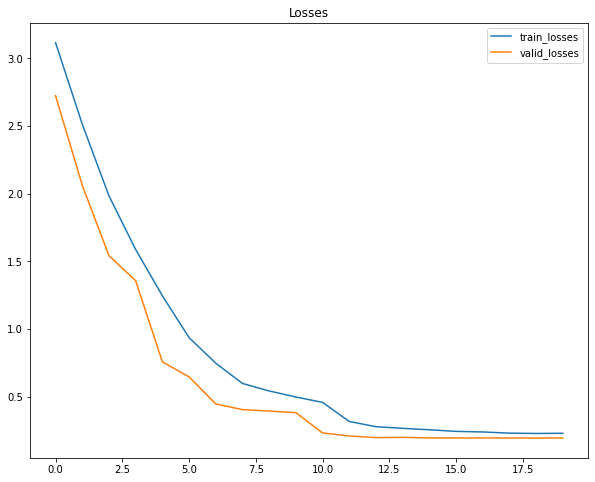

In [61]:
%matplotlib inline

plt.figure(figsize=(10,8))
plt.plot(train_losses, label="train_losses")
plt.plot(valid_losses, label="valid_losses")
plt.legend()
plt.title("Losses")

In [62]:
net.eval()

Network(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.4, inplace=False)
  (fc3): Linear(in_features=270, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=26, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [66]:
@interact(sample = (0, len(test_data)))
def show_image_dataset(sample):
    info, label  = test_data[sample], labels_test[sample]
    pixels       = info.reshape(IMAGE_SIZE, IMAGE_SIZE)

    input_pixels    = info.reshape(1, IMAGE_SIZE, IMAGE_SIZE).tolist()
    predicted_label = net.evaluate(torch.FloatTensor([input_pixels]))
    
    _, ax = plt.subplots(figsize=(3.5, 3.5))
    sns.heatmap(data=pixels, cmap="YlGnBu", ax=ax)

    actual    = f"{num_to_letter(label)} ⟵ actual"
    predicted = f"{num_to_letter(predicted_label)} ⟵ predicted"
    plt.title(actual + "\n" + predicted, fontsize=20, color="#00008b", loc="left")

    plt.show()

interactive(children=(IntSlider(value=1793, description='sample', max=3587), Output()), _dom_classes=('widget-…

<img src="./after.png" width="60%" />

In [64]:
prediction = net.evaluate(Variable(test_data_formated))
accuracy = net.accuracy(prediction, test_labels)

n = len(prediction)
correct = int(n * accuracy)
print(f"Correct predictions: {correct} / {n}: ", end="")
print(f"{round(accuracy, 6)}")

Correct predictions: 3388 / 3587: 0.944522
